In [3]:
!pip install -q datasets tensorflow pillow nltk

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from datasets import load_dataset
from PIL import Image
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("Dependencies installed successfully!")


Dependencies installed successfully!


In [4]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove
print("GloVe embeddings downloaded successfully!")


replace glove/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace glove/glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace glove/glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace glove/glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
GloVe embeddings downloaded successfully!


In [5]:
def load_glove_embeddings():
    embeddings = {}
    print("Loading GloVe embeddings...")
    with open("glove/glove.6B.100d.txt", encoding="utf-8") as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            embeddings[values[0]] = np.asarray(values[1:], dtype="float32")
    print(f"Loaded {len(embeddings)} word vectors")
    return embeddings

glove_embeddings = load_glove_embeddings()

def preprocess_image(image):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(np.uint8(image))
    orig_w, orig_h = image.size
    image = image.convert("RGB").resize((224, 224))
    return np.array(image, dtype=np.float32) / 255.0, orig_w, orig_h

def preprocess_text(text):
    tokens = word_tokenize(text.lower())[:15]
    vecs = [(glove_embeddings[w] if w in glove_embeddings else np.zeros(100)) for w in tokens]
    while len(vecs) < 15:
        vecs.append(np.zeros(100))
    return np.stack(vecs)

def normalize_bbox(bbox, img_w, img_h):
    x, y, w, h = bbox
    return [x/img_w, y/img_h, w/img_w, h/img_h]

print("Preprocessing functions ready!")


Loading GloVe embeddings...


Loading GloVe: 400000it [00:08, 45292.28it/s]

Loaded 400000 word vectors
Preprocessing functions ready!


In [6]:
def load_simple_dataset(num_samples=4000):
    X_img, X_txt, y_bbox, desc = [], [], [], []
    try:
        print("Loading RefCOCO...")
        ds = load_dataset("lmms-lab/RefCOCO")["val"]
        cnt = 0
        for ex in tqdm(ds, total=min(len(ds), num_samples*2)):
            if cnt >= num_samples: break
            text = ex["answer"][0]
            bbox = ex["bbox"]
            if len(text.split()) < 3 or len(bbox)!=4 or bbox[1]<=0 or bbox[2]<=0:
                continue
            img_arr, w, h = preprocess_image(ex["image"])
            nb = normalize_bbox(bbox, w, h)
            if not (0.01<nb[2]<0.9 and 0.01<nb[2]<0.9):
                continue
            X_img.append(img_arr)
            X_txt.append(preprocess_text(text))
            y_bbox.append(nb)
            desc.append(text)
            cnt += 1
        if len(X_img)==0:
            raise ValueError("No valid samples")
        print(f"Processed {len(X_img)} RefCOCO samples")
    except Exception as e:
        print(f"RefCOCO failed ({e}), creating synthetic data...")
        X_img, X_txt, y_bbox, desc = [], [], [], []
        phrases = [
            "woman selling vegetables at market","person playing tennis on court",
            "man eating food at table","child running in playground",
            "woman cooking in kitchen","person reading book on bench",
            "man playing guitar on stage","woman walking dog in park",
            "person riding bicycle on street","child playing with toys on floor",
            "man working on computer","woman talking on phone",
            "person sitting on chair","child eating ice cream",
            "man driving car","woman brushing teeth",
            "person swimming in pool","child drawing on paper",
            "man lifting weights","woman dancing at party"
        ]
        for i in tqdm(range(num_samples)):
            img = np.random.rand(224,224,3).astype(np.float32)
            phr = phrases[i % len(phrases)]
            bb = [np.random.uniform(0.1,0.4) for _ in range(4)]
            X_img.append(img)
            X_txt.append(preprocess_text(phr))
            y_bbox.append(bb)
            desc.append(phr)
        X_img = np.array(X_img)
        X_txt = np.array(X_txt)
        y_bbox = np.array(y_bbox)
        print(f"Created {len(X_img)} synthetic samples")
    return np.array(X_img), np.array(X_txt), np.array(y_bbox), desc

X_img, X_txt, y_bbox, descriptions = load_simple_dataset(4000)
print(f"Total samples: {len(X_img)}")


Loading RefCOCO...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
 80%|███████▉  | 6368/8000 [00:47<00:12, 134.11it/s]


Processed 4000 RefCOCO samples
Total samples: 4000


In [7]:
import tensorflow.keras.backend as K

def smooth_l1_loss(y_true, y_pred, delta=0.8):
    diff = K.abs(y_true - y_pred)
    return K.mean(K.switch(diff<delta, 0.5*K.square(diff), delta*diff-0.5*delta*delta))

def iou_loss_stable(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-3, .999)
    x1, y1, w1, h1 = y_true[:,0],y_true[:,1],y_true[:,2],y_true[:,3]
    x2, y2 = x1+w1, y1+h1
    px1, py1, pw1, ph1 = y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3]
    px2, py2 = px1+pw1, py1+ph1
    ix1, iy1 = K.maximum(x1,px1), K.maximum(y1,py1)
    ix2, iy2 = K.minimum(x2,px2), K.minimum(y2,py2)
    inter = K.maximum(0.,ix2-ix1)*K.maximum(0.,iy2-iy1)
    union = w1*h1 + pw1*ph1 - inter + 1e-7
    return 1 - K.mean(inter/union)

def sgd_optimized_loss(y_true, y_pred):
    return 0.5*smooth_l1_loss(y_true,y_pred) + 0.5*iou_loss_stable(y_true,y_pred)

print("Building model...")
img_in = Input((224,224,3))
res = ResNet50(weights="imagenet", include_top=False, input_tensor=img_in)
for layer in res.layers[:-8]:
    layer.trainable=False
f_img = tf.keras.layers.GlobalAveragePooling2D()(res.output)
f_img = tf.keras.layers.BatchNormalization()(f_img)
f_img = Dense(256, activation="relu")(f_img)
f_img = Dropout(0.4)(f_img)

txt_in = Input((15,100))
f_txt = tf.keras.layers.GlobalAveragePooling1D()(txt_in)
f_txt = tf.keras.layers.BatchNormalization()(f_txt)
f_txt = Dense(256, activation="relu")(f_txt)
f_txt = Dropout(0.4)(f_txt)

merged = Concatenate()([f_img, f_txt])
merged = tf.keras.layers.BatchNormalization()(merged)
merged = Dense(128, activation="relu")(merged)
merged = Dropout(0.3)(merged)
merged = Dense(64, activation="relu")(merged)
out = Dense(4, activation="sigmoid")(merged)

model = Model([img_in, txt_in], out)
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, clipnorm=1.0),
    loss=sgd_optimized_loss,
    metrics=["mae"]
)
model.summary()


Building model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,222,932 (92.40 MB)

 Trainable params: 4,045,452 (15.43 MB)

 Non-trainable params: 20,177,480 (76.97 MB)

In [8]:
print(f"Sizes— X_img: {len(X_img)}, X_txt: {len(X_txt)}, y: {len(y_bbox)}")
assert len(X_img)==len(X_txt)==len(y_bbox), "Size mismatch"
if len(X_img)==0: raise ValueError("Empty dataset!")

split = int(0.85*len(X_img))
X_img_tr, X_img_val = X_img[:split], X_img[split:]
X_txt_tr, X_txt_val = X_txt[:split], X_txt[split:]
y_tr, y_val = y_bbox[:split], y_bbox[split:]
print(f"Train: {len(X_img_tr)}, Val: {len(X_img_val)}")

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
]

history = model.fit(
    [X_img_tr, X_txt_tr], y_tr,
    validation_data=([X_img_val, X_txt_val], y_val),
    epochs=30, batch_size=8,
    callbacks=callbacks, verbose=1
)


Sizes— X_img: 4000, X_txt: 4000, y: 4000
Train: 3400, Val: 600
Epoch 1/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - loss: 0.4353 - mae: 0.2428 - val_loss: 0.4051 - val_mae: 0.2070 - learning_rate: 0.0100
Epoch 2/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.4093 - mae: 0.2130 - val_loss: 0.3824 - val_mae: 0.1879 - learning_rate: 0.0100
Epoch 3/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.3890 - mae: 0.1855 - val_loss: 0.3812 - val_mae: 0.1706 - learning_rate: 0.0100
Epoch 4/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.3839 - mae: 0.1809 - val_loss: 0.3717 - val_mae: 0.1631 - learning_rate: 0.0100
Epoch 5/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.3765 - mae: 0.1757 - val_loss: 0.3711 - val_mae: 0.1712 - learning_rate: 0.0100
Epoch 6/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.3782 - mae: 0.1788 - val_loss: 0.3645 - val_mae: 0.1657 - learning_rate: 0.0100
Epoch 7/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.3767 - ma

Avg IoU: 0.309, >0.3: 51.3%, >0.5: 16.2%


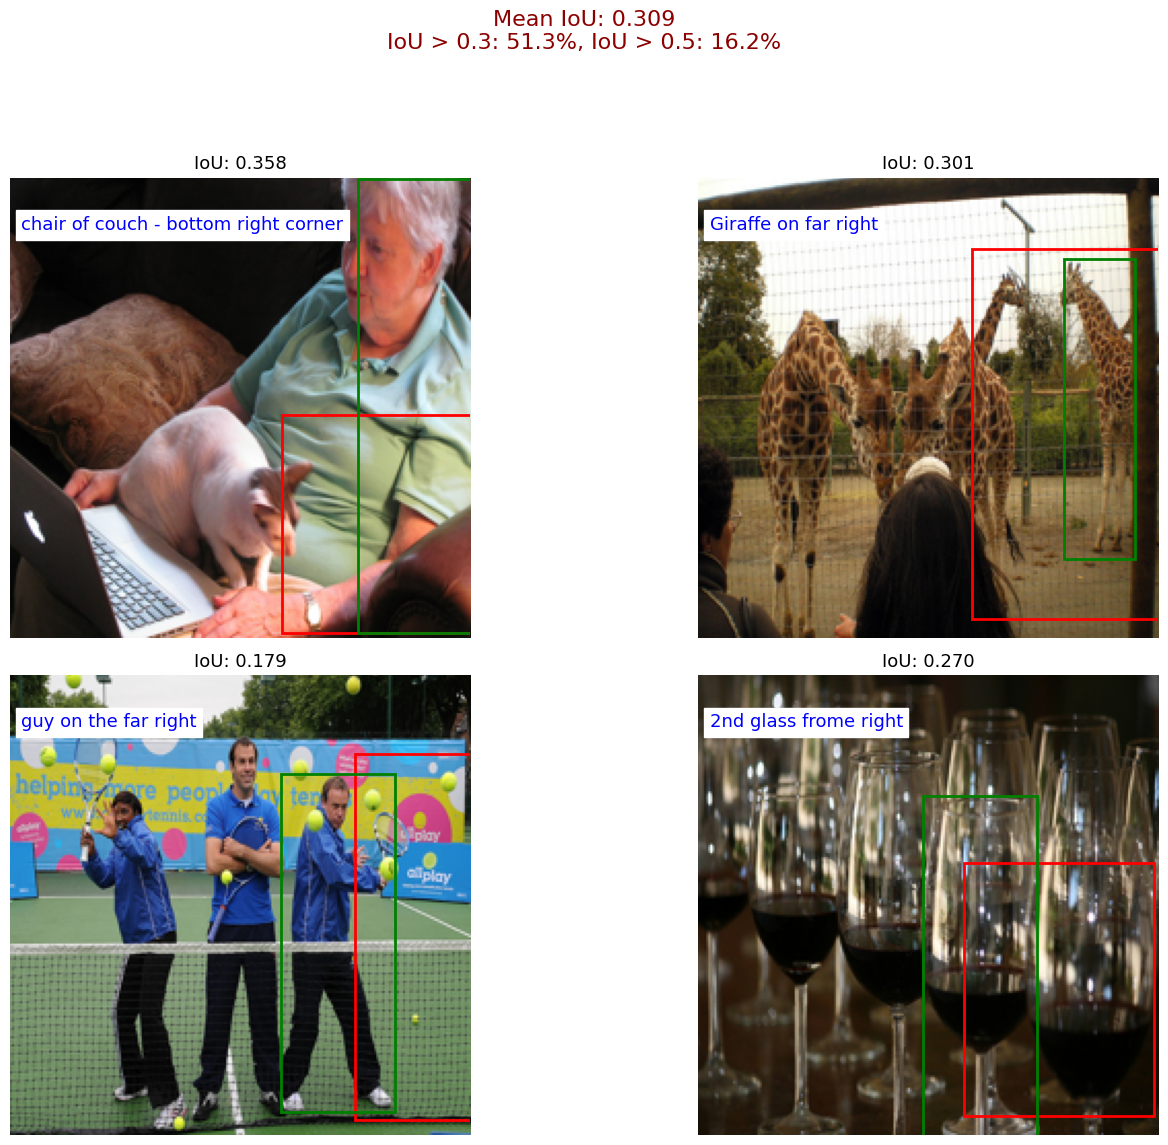

In [10]:
# Calculate IoU for each validation sample
def calculate_iou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    if xi2 <= xi1 or yi2 <= yi1: return 0
    inter = (xi2 - xi1) * (yi2 - yi1)
    union = w1 * h1 + w2 * h2 - inter
    return inter / union

preds = model.predict([X_img_val, X_txt_val], verbose=0)
ious = [calculate_iou(preds[i], y_val[i]) for i in range(len(preds))]
mean_iou = np.mean(ious)
iou_03 = np.mean(np.array(ious) > 0.3)
iou_05 = np.mean(np.array(ious) > 0.5)

print(f"Avg IoU: {mean_iou:.3f}, >0.3: {iou_03:.1%}, >0.5: {iou_05:.1%}")

# Plot results with text and IoU displayed
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx >= len(X_img_val): break
    ax.imshow(X_img_val[idx])
    pred, true = preds[idx], y_val[idx]
    # Draw predicted box (red) and true box (green)
    for box, color, label in [(pred, 'red', 'Predicted'), (true, 'green', 'Ground Truth')]:
        bx, by, bw, bh = box * 224
        bx, by = max(0, bx), max(0, by)
        bw = min(224, bw)
        bh = min(224, bh)
        rect = plt.Rectangle((bx, by), bw, bh, fill=False, color=color, linewidth=2, label=label)
        ax.add_patch(rect)
    # Put referring expression text above the image
    if descriptions:  # Only if you have referring expressions available
        ax.text(5, 25, descriptions[split+idx], fontsize=13, color='blue', backgroundcolor='white')
    ax.set_title(f"IoU: {ious[idx]:.3f}", fontsize=13)
    ax.axis('off')

fig.suptitle(
    f"Mean IoU: {mean_iou:.3f}\nIoU > 0.3: {iou_03:.1%}, IoU > 0.5: {iou_05:.1%}",
    fontsize=16,
    color="darkred"
)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()
